# Importing section

In [1]:
import urllib.request
import re
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import geoip2.database

from pyspark.sql import SparkSession
from datetime import datetime
from collections import defaultdict

In [2]:
warnings.filterwarnings("ignore")

# Getting log and initialize spark

In [3]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

spark = SparkSession.builder.getOrCreate()
spark
sc = spark.sparkContext

24/10/29 09:08:35 WARN Utils: Your hostname, MacBook-Pro-BartomiejK.local resolves to a loopback address: 127.0.0.1; using 10.129.4.254 instead (on interface en0)
24/10/29 09:08:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/29 09:08:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Zadanie nr 1

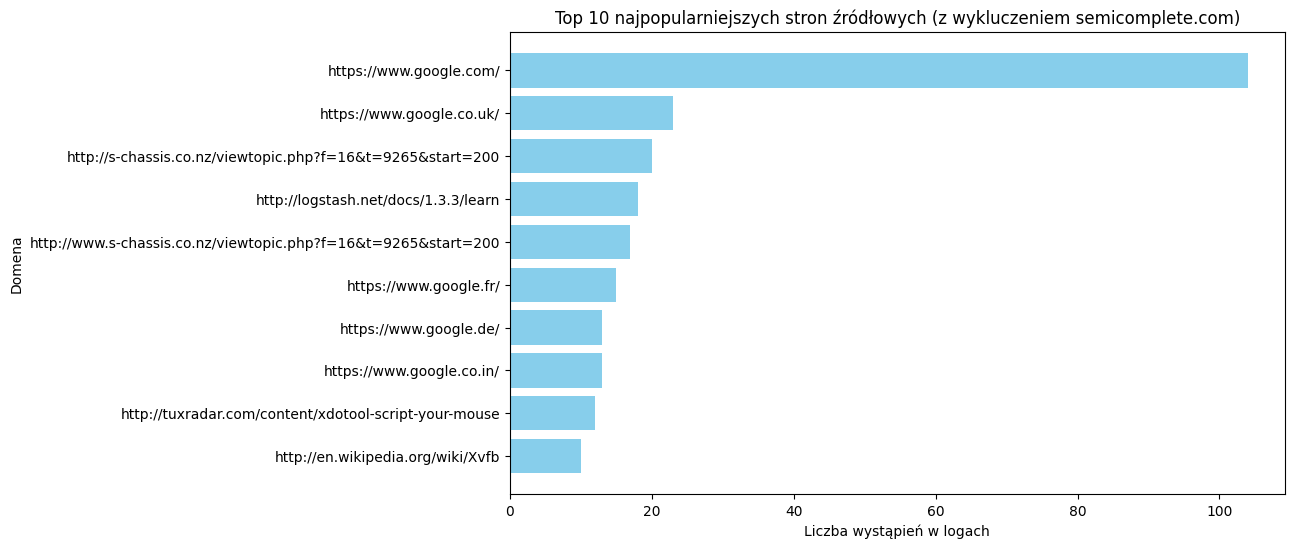

In [4]:
RDD_logs = sc.textFile("apache_logs")

def parse_log_line(line):
    try:
        parts = line.split(' ')
        referer = parts[10].strip('"')
        if referer != "-" and "semicomplete.com" not in referer:
            return referer
    except Exception as e:
        pass
    return None

def plot(rf_df):
    plt.figure(figsize=(10, 6))
    plt.barh(rf_df['referer'], rf_df['count'], color='skyblue')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Domena')
    plt.title('Top 10 najpopularniejszych stron źródłowych (z wykluczeniem semicomplete.com)')
    plt.gca().invert_yaxis()
    plt.show()

referers_rdd = RDD_logs.map(parse_log_line).filter(lambda x: x is not None)
referer_counts = referers_rdd.map(lambda referer: (referer, 1)).reduceByKey(lambda a, b: a + b)

referer_df = referer_counts.toDF(["referer", "count"])
referer_df_pandas = referer_df.toPandas()

# zmienić head w razie potrzeby
referer_df_pandas_sorted = referer_df_pandas.sort_values(by = "count", ascending = False).head(10)

plot(referer_df_pandas_sorted)

# Zadanie nr 2

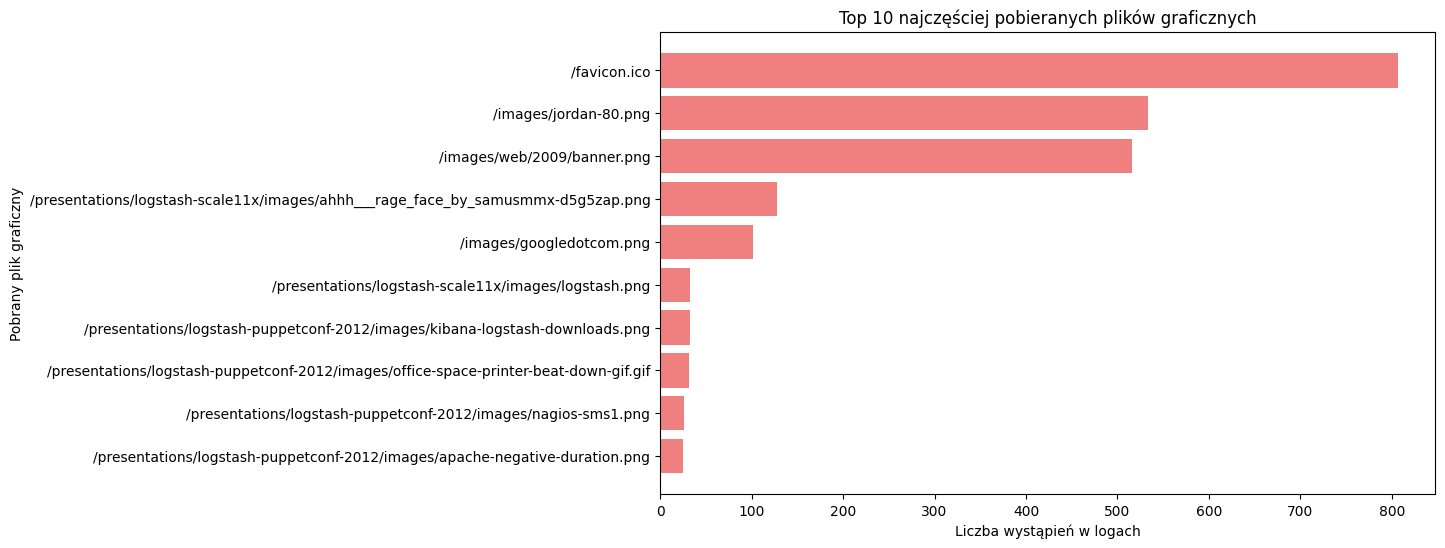

In [5]:
def parse_log_line_for_images(line):
    try:
        parts = line.split(' ')
        request = parts[6]
        if any(ext in request for ext in ['.jpg', '.png', '.gif', '.ico']):
            return request
    except Exception as e:
        pass
    return None

def plot_img(imdf):
    plt.figure(figsize=(10, 6))
    plt.barh(imdf['image'], imdf['count'], color='lightcoral')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Rodzaj pliku graficznego')
    plt.title('Top 10 najczęściej pobieranych plików graficznych')
    plt.gca().invert_yaxis()
    plt.show()

images_rdd = RDD_logs.map(parse_log_line_for_images).filter(lambda x: x is not None)
image_counts = images_rdd.map(lambda image: (image, 1)).reduceByKey(lambda a, b: a + b)

image_df = image_counts.toDF(["image", "count"])
image_df_pandas = image_df.toPandas()

# zmienić head w razie potrzeby, analogicznie jak w przypadku referer_df_pandas_sorted
image_df_pandas_sorted = image_df_pandas.sort_values(by = "count", ascending = False).head(10)

def plot_img(imdf):
    plt.figure(figsize=(10, 6))
    plt.barh(imdf['image'], imdf['count'], color='lightcoral')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Pobrany plik graficzny')
    plt.title('Top 10 najczęściej pobieranych plików graficznych')
    plt.gca().invert_yaxis()
    plt.show()

plot_img(image_df_pandas_sorted)


# Zadanie nr 3

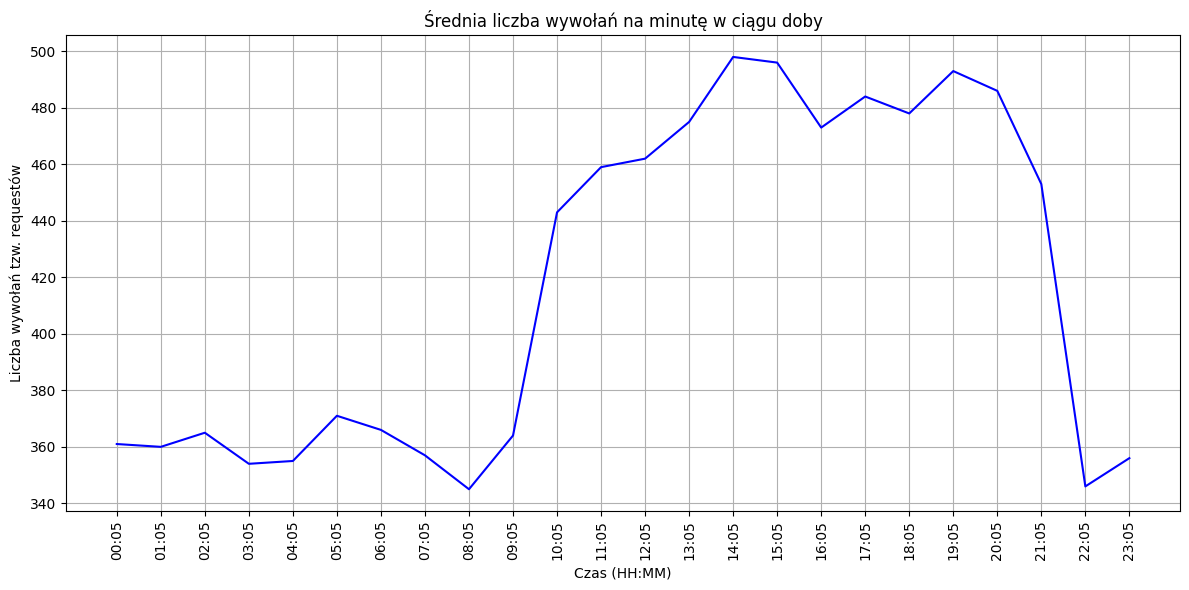

In [6]:
def parse_log_line_for_time(line):
    try:
        parts = line.split(' ')
        timestamp = parts[3].strip('[')
        dt = datetime.strptime(timestamp, "%d/%b/%Y:%H:%M:%S")
        # zwracamy czas w minutach, żeby łatwiej było grupować, można też zwrócić pełną datę
        return dt.hour * 60 + dt.minute
    except Exception as e:
        return None
    
def plot_time(tdf):
    plt.figure(figsize=(12, 6))
    plt.plot(tdf['time'], tdf['count'], color = 'blue', linewidth = 1.5)
    plt.xticks(rotation = 90)
    plt.xlabel('Czas (HH:MM)')
    plt.ylabel('Liczba wywołań tzw. requestów')
    plt.title('Średnia liczba wywołań na minutę w ciągu doby')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

times_rdd = RDD_logs.map(parse_log_line_for_time).filter(lambda x: x is not None)
time_counts = times_rdd.map(lambda minute: (minute, 1)).reduceByKey(lambda a, b: a + b)

time_df = time_counts.toDF(["minute_of_day", "count"])
time_df_pandas = time_df.toPandas()

time_df_pandas['time'] = time_df_pandas['minute_of_day'].apply(lambda x: f"{x//60:02d}:{x%60:02d}")
time_df_pandas_sorted = time_df_pandas.sort_values(by = "minute_of_day")

plot_time(time_df_pandas_sorted)

# Zadanie nr 4

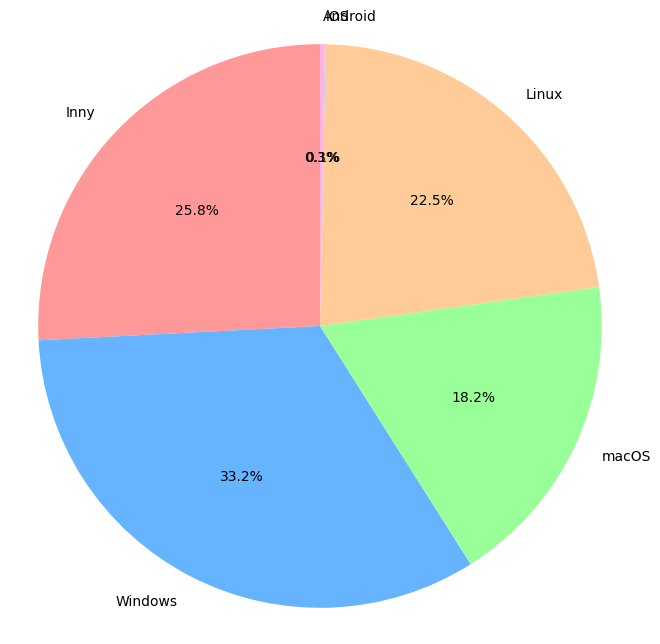

In [7]:
def parse_log_line_for_os(line):
    try:
        user_agent = re.search(r'\"([^\"]*)\"$', line).group(1)
        
        if "Windows" in user_agent:
            return "Windows"
        elif "Macintosh" in user_agent or "Mac OS" in user_agent:
            return "macOS"
        elif "Linux" in user_agent:
            return "Linux"
        elif "Android" in user_agent:
            return "Android"
        elif "iPhone" in user_agent or "iPad" in user_agent:
            return "iOS"
        else:
            return "Inny"
    except Exception as e:
        return "Inny"
    
def plot_os(osdf):
    plt.figure(figsize=(8, 8))
    plt.pie(osdf['count'], labels = osdf['os'], autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
    plt.axis('equal')
    plt.show()

os_rdd = RDD_logs.map(parse_log_line_for_os)
os_counts = os_rdd.map(lambda os: (os, 1)).reduceByKey(lambda a, b: a + b)

os_df = os_counts.toDF(["os", "count"])
os_df_pandas = os_df.toPandas()

plot_os(os_df_pandas)

# Zadanie nr 5

## Podejście nr 1

In [8]:
# sprawdzamy na czystko w logach czy nie widnieje zapis jakoby ktoś był bot, crawler, spider, itp.

def is_bot_or_not(user_agent):
    bot_list: list[str] = ['bot', 'crawl', 'spider', 'slurp', 'Googlebot', 'Bingbot', 'Baiduspider', 'YandexBot']
    return any(bot in user_agent for bot in bot_list)

def parse_log_line_for_bot(line):
    try:
        user_agent = re.search(r'\"([^\"]*)\"$', line).group(1)
        return is_bot_or_not(user_agent)
    except Exception as e:
        return False
    
bot_rdd = RDD_logs.map(parse_log_line_for_bot)

bot_count = bot_rdd.filter(lambda x: x).count()
non_bot_count = bot_rdd.filter(lambda x: not x).count()

# wyniki w procentach
total_requests = bot_count + non_bot_count
bot_percentage = (bot_count / total_requests) * 100

print(f"Procent ruchu generowanego przez boty na podstawie User-Agent: {bot_percentage:.2f}%")

Procent ruchu generowanego przez boty na podstawie User-Agent: 13.87%


## Podejście nr 2

In [9]:
# podejście nr 2 jest trochę bardziej skomplikowane, ale moim prywatnym zdaniemm bardziej precyzyjne. Będzie zliczana ilość requestów z jednego IP w danej jednostce czasu. Tak na oko, bot powinien generować znacznie więcej requestów niż człowiek.

def parse_log_line_for_ip_and_time(line):
    try:
        parts = line.split(' ')
        ip = parts[0]
        time_str = parts[3].strip('[')
        time_obj = datetime.strptime(time_str, '%d/%b/%Y:%H:%M:%S')
        return (ip, time_obj)
    except Exception as e:
        return None

def group_requests_by_ip(data):
    ip_requests = defaultdict(list)
    for ip, time in data:
        ip_requests[ip].append(time)
    return ip_requests

ip_time_rdd = RDD_logs.map(parse_log_line_for_ip_and_time).filter(lambda x: x is not None)
ip_requests = group_requests_by_ip(ip_time_rdd.collect())

bot_ips = []
for ip, times in ip_requests.items():
    times.sort()
    time_diff = (times[-1] - times[0]).seconds
    
    if time_diff == 0:
        time_diff = 1
    
    request_rate = len(times) / (time_diff / 60)
    
    # próg requestów na minutę, powyżej którego uznajemy, że to bot, w zasadzie jedyny haczyk to, że trzeba go dostosować do danych
    if request_rate > 7:
        bot_ips.append(ip)

bot_ip_rdd = ip_time_rdd.filter(lambda x: x[0] in bot_ips)
bot_ip_count = bot_ip_rdd.count()

total_requests = ip_time_rdd.count()
bot_percentage_ip = (bot_ip_count / total_requests) * 100

print(f"Procent ruchu generowanego przez boty na podstawie wzorców zachowań: {bot_percentage_ip:.2f}%")

Procent ruchu generowanego przez boty na podstawie wzorców zachowań: 39.21%


# Zadanie nr 6

In [10]:
MMDB_PATH = 'GeoLite2-City.mmdb'

def get_ip_location(ip):
    try:
        with geoip2.database.Reader(MMDB_PATH) as reader:
            response = reader.city(ip)
            lat = response.location.latitude
            lon = response.location.longitude
            country = response.country.name
            return {'ip': ip, 'lat': lat, 'lon': lon, 'country': country}
    except Exception as e:
        print(f"Błąd przy przetwarzaniu IP: {ip}, {str(e)}")
        return None

def parse_log_line_for_ip(line):
    try:
        return line.split(' ')[0]
    except Exception as e:
        return None

log_file_path = 'apache_logs'
with open(log_file_path, 'r') as log_file:
    log_lines = log_file.readlines()

ip_list = [parse_log_line_for_ip(line) for line in log_lines if parse_log_line_for_ip(line) is not None]

# usuwanie duplikatów
ip_list = list(set(ip_list))

locations = [get_ip_location(ip) for ip in ip_list if get_ip_location(ip) is not None]
df = pd.DataFrame(locations)


if not df.empty:
    fig = px.scatter_geo(df, lat='lat', lon='lon', color='country', hover_name='ip',
                         projection="natural earth", title="Lokalizacje klientów na podstawie adresów IP")
    fig.show()
else:
    print("Brak lokalizacji do wyświetlenia.")
